## Task 0 (Know your Data) - Exploratory Data Analysis

## 0.1. Loading Data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import statistics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import neighbors,tree, preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, recall_score, accuracy_score
import sklearn.naive_bayes #import GaussianNB, MultinomialNB, CategoricalNB, BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier 
import re
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier

In [11]:
df = pd.read_csv('PetFinder_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

Loading colour, breed and state labels:

In [12]:
color_labels = pd.read_csv('color_labels.csv').set_index('ColorID')
breed_labels = pd.read_csv('breed_labels.csv').set_index('BreedID')
state_labels = pd.read_csv('state_labels.csv').set_index('StateID')

## 0.2. Understanding Data

### Basic Questions

#### How big is the dataset?
The dataset contains 14993 entries with 24 features each.

#### Is this the entire dataset?
The original dataset from PetFinder.my contains over 150,000 animal profiles.

#### Is this data representative enough?
The dataset represents ~10% of the original data. EDA is required to best assess whether it can be considered a representative sample of the original population.

#### Are there likely to be gross outliers or extraordinary sources of noise?
EDA can shed light on this topic, by representing data distribution and irregularities that could point to errors in data.

#### Are there any fields that are unique identifiers? These are the fields you might use for joining between datasets, etc.
All animal profiles are uniquely identified by a PetID. Each PetID also has a non-unique RescuerID, and a non-unique State.

#### When data entries are blank, where does that come from?
Some animal profiles have no assigned name. There are also some features which have a default value set for cases in which that feature is not specified or applicable to the data entry.

#### How common are blank entries?
There are ~1200 blank name entries, which constitute a significant portion of the data. It would perhaps be best to keep this data in the dataset for analysis. Other features with default value entries should also be kept, because, like a profile without a name, unspecified animal characteristics have a meaning relevant to our objectives.

## Exploratory Data Analysis

In order to better understand our dataset and to make decisions about feature selection, feature extraction and general cleaning of the data, we started by plotting distribution of the original features and the target.

### Target: *AdoptionSpeed*

The target feature displayed a clear discrepancy in distribution, showing a significantly lower number of examples for AdoptionSpeed = 0. This imbalance should be addressed, as models tend to neglect minority classes if they don't have a large enough representation in the overall dataset, therefore compromising the classification.

In [ ]:
ax = sns.catplot(x="AdoptionSpeed",data=df, kind='count')
(ax.set_axis_labels("Adoption Speed", "Number of Pets"))

### Overall correlations
The plot bellow illustrates the absolute correlation between  each feature and the target class "AdoptionSpeed". All correlations are very low (<15%)

In [ ]:
numeric_df = df.select_dtypes(exclude=['object'])
corr_dict = {}
for feature in numeric_df.columns:
    corr_dict[feature] = abs(df['AdoptionSpeed'].corr(df[feature]))
    #print(feature, '-->', corr_dict[feature])
    
corr_dict.pop('AdoptionSpeed')
plt.figure(figsize=(20,7))
plt.bar(range(len(corr_dict)), list(corr_dict.values()), align='center')
plt.xticks(range(len(corr_dict)), list(corr_dict.keys()))

### PetID

Since PetID is not informative of the pet profile (it acts solely as a unique identifier of the page), it would be excluded from the analysis, although it will be used as an index for the dataFrame. It can be later useful when evaluating model performance, as the respective record values can reveal if certain features were appropriately categorised.

In [3]:
df.set_index("PetID", inplace=True) # change index to PetId
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,...,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,...,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,2.0,0
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,...,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,7.0,3
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,...,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",8.0,2
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,...,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,3.0,2


### Strategy

The following analysis was done to each feature:
* Check the number of examples for each feature values.
* Check the distribution of each feature values' among AdoptionSpeed classes.

For the second step we used the following visualisation method, which returns not only a plot on the distribution but also a table of representativity percentage gain of each feature's values for each AdoptionSpeed class, relatively to AdoptionSpeed=0:

In [4]:
# creates a stacked bar plot for any two categorical variables
# also creates a relative frequency version of the same plot
# and a relative gain compared to AdoptionSpeed=0 
# frel=False to return only the absolute frequency plot

def cat_distr_pairwise(cat_x,cat_y, df, frel):
    
    unique_cat_y = sorted(df[cat_y].unique()) #ordered list of categories in variable y
    unique_cat_x = sorted(df[cat_x].unique()) #ordered list of categories in variable x
    cat_count = pd.DataFrame(columns=unique_cat_y,index=unique_cat_x) #DataFrame of x categories by y categories
    for y in unique_cat_y: #count each type of y category...
        for x in unique_cat_x: #... for each type of x category (e.g.: all dogs' adoption speed, then all cats' adoption speed)
            count = df[cat_y][(df[cat_x]==x) & (df[cat_y]==y)].count() 
            cat_count.at[x,y] = count 
    
    def color(val):
        if val < 0:
            color = 'red'
        elif val>0:
            color = 'green'
        else:
            color='white'
        return 'background-color: %s' % color
    
    if frel==False:
        
        #relative gain table
        relgain = cat_count.pct_change().cumsum() * 100
        print("Relative gain from AdoptionSpeed=0 (%):")
        display(relgain.style.applymap(color))
        # alternative: display(relgain.style.bar(align='zero', color=['#d65f5f', '#5fba7d'])
        return cat_count.plot.bar(stacked=True, figsize=(10,7))
    
    else:
        #relative frequency stacked bar plot
        freq_cat_count = cat_count.divide(cat_count.sum(axis=1), axis=0)
        
        #relative gain table
        relgain = freq_cat_count.pct_change().cumsum() * 100
        print("Relative gain from AdoptionSpeed=0 (%):")
        display(relgain.style.applymap(color))
        # alternative: display(relgain.style.bar(align='zero', color=['#d65f5f', '#5fba7d'])

        return freq_cat_count.plot.bar(stacked=True, figsize=(10,7), title=cat_y + " relative distribution among AdoptionSpeed")
    

We will now present the most important conclusions taken from this analysis.

### Type

Because we are going to later create type-specific predictive models, it would be relevant to see the number of cases we have in our dataset for each animal (cat or dog).

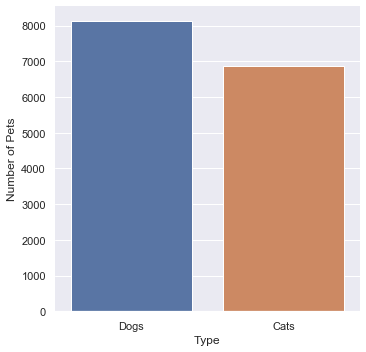

In [5]:
bx = sns.catplot(x="Type",data=df, kind='count')
(bx.set_axis_labels("Type", "Number of Pets")
    .set_xticklabels(["Dogs", "Cats"])
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

In [ ]:
cat_distr_pairwise('AdoptionSpeed','Type', df, frel=True)

Looking at our data, the number of examples of dogs and cats is fairly proportional, as well as their relative distribution among target classes. 
Looking at the gain table, it is clear that dogs(1) tend to get adopted later relatively to cats(2),  which we can see by the growing relative gain. In fact, the number of dogs with no adoption after 100 days (adoptionSpeed=4) is 37% higher than dogs being adopted on the same day (adoptionSpeed=0). On the other hand, we observe the opposite phenomena on cats. They tend to be adopted at ealier stages, being the number of cats with no adoption after 100 days (adoptionSpeed=4) is 29% lower than cats being adopted on the same day (adoptionSpeed=0).
Despite this small discrepancies, we expect the resulting models' performance to be comparable.



### Name
Since a reasonable amount of the profiles didn't make any reference to name (empty) a first approach would be to fill those empty values with a fixed value such as "No Name" or similar.
Other approach would be to transform this feature into a binary one with a 0 value for profiles with no name and a 1 value for the opposite.
Since it was later found that some of the named profiles were filled with "No Name" and derivatives of this name such as "No Name Yet", "V6", "å°è±¹çº¹" etc., which are not proper names, we made an attempt to classify those cases as "No name" as well.

A glimpse on the ignored names: ['No Name Yet', 'No Name', 'No Name', 'H3', 'Z3', 'C', 'No Name', 'No Name', 'BB', 'QQ', 'Y1', 'No Name', 'H1', 'No Name Yet', 'D9', 'Y4', 'No Name', 'Z4', 'No Name', 'Unnamed', 'BB', 'DD', 'M2', 'H6', 'D4', 'QQ', 'JJ', 'No Names', 'å°\x8fè±¹çº¹', 'ä¼\x98ç¾\x8eå\x8f¯ç¬\x91', 'F1', 'æ©\x98å\xad\x90', 'W7', '(No Name)', 'No Name Yet', 'No Name', '1F', 'Q1', '6', 'CJ', '3F', '[No Name]', 'BB', 'KD', 'No Name Yet', 'No Name Yet', 'DD', 'No Name', 'G1', 'è\x8f\x9cè\x8f\x9cã\x80\x82']


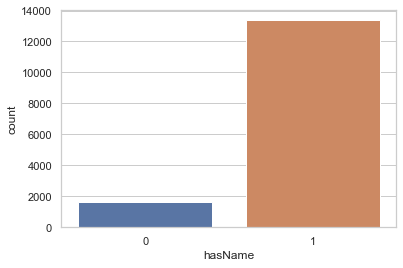

In [13]:
# Create new feature - hasNames
l = []
ignore = []

for i in df["Name"]:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        if len(i)<3: #Consider that a 2 letter name is not a proper name.
            l.append(0)
            ignore.append(i)
        elif re.search("[a-zA-Z]", i) == None: #If name doesn't have letters, it's not a proper name.
            l.append(0)
            ignore.append(i)
        elif re.search("unnamed|no name",i, re.IGNORECASE) != None: 
            #If name string includes "unnamed" or "no name", it's not a proper name
            l.append(0)
            ignore.append(i)
        elif len(i.split())>0:
            l.append(1)

print("A glimpse on the ignored names:",ignore[:50])
df_processed1 = df.copy()
df_processed1.drop("Name", axis=1, inplace = True)
df_processed1.insert(1,"hasName",l) ##INSERT IN DATAFRAME

sns.set(style="whitegrid")
ax = sns.countplot(x="hasName", data=df_processed1)

Relative gain from AdoptionSpeed=0 (%):


,0,1
0,nan,nan
1,28.3828,-2.81545
2,14.3321,-0.974261
3,9.85559,-0.479193
4,38.1045,-3.44873


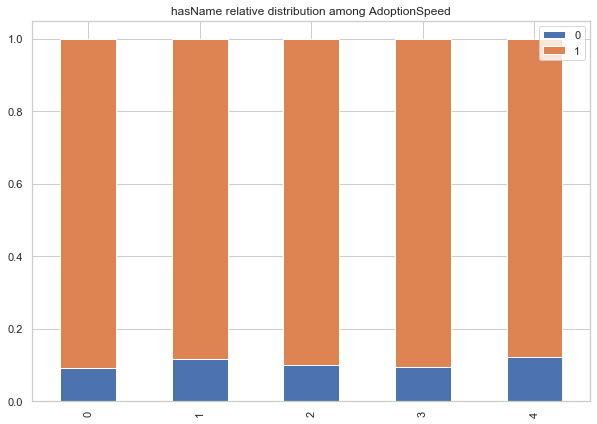

In [14]:
cat_distr_pairwise('AdoptionSpeed','hasName', df_processed1, frel=True)

As we can see from the plot above, the relative distribution of the "noName" feature values among "AdoptionSpeed" classes is very similar. This probabably means that the pet's name is not a very important factor in the adopter's decision.

### Age

When looking at the Age distribution, we can see that there are peaks every 12 months. Young pets (less than 1 year old) are the most frequent.

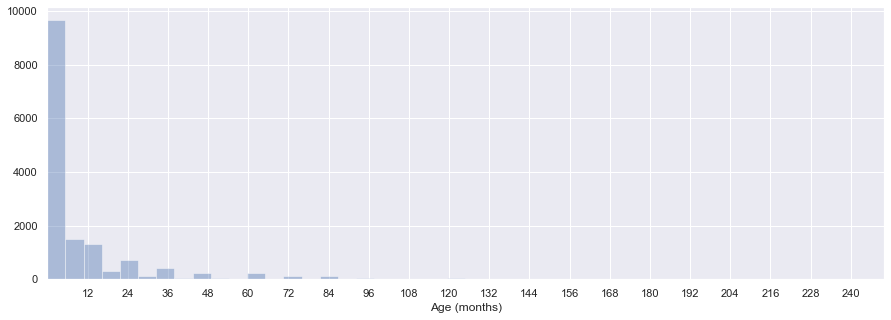

In [15]:
a = df['Age'] # get Age array
nr_bins = 1 + 3.322*math.log(len(a),2) # Number of bins according to Sturges rule
sns.set(rc={'figure.figsize':(15,5)}) # set figure size

# setting up the axis
fig, ax = plt.subplots()
ticks = [i for i in range(0,260,12)]
ticks.pop(0)
ax.set_xticks(ticks)
plt.xlim([0.0,250])

sns.distplot(a, bins=round(nr_bins), kde=False, axlabel="Age (months)");

The average cat is considered a kitten roughly until it reaches the age of 1 year old. The same goes for puppies. On the other hand, dogs and cats are considered Seniors roughly when they reach the age of 6 years. Of course, these are approximations, as the classification varies with the type of animal (cats or dogs), breed, size and many other factors.

In this sense, we will consider these categories:
* Baby - age 0-11 months => 0
* Adult - age 12-71 months =>1
* Senior - age 72-250 months =>2

In [16]:
# Create new feature - AgeGroup
AgeGroup = []
for i in df["Age"]:
    if i<12:
        AgeGroup.append(0)
    elif i<72:
        AgeGroup.append(1)
    else:
        AgeGroup.append(2)

df_processed2 = df_processed1.copy()
df_processed2.drop("Age", axis=1, inplace = True)
df_processed2.insert(2,"AgeGroup",AgeGroup) ##INSERT IN DATAFRAME

In [ ]:
cat_distr_pairwise('AdoptionSpeed','AgeGroup', df_processed2, frel=True)

The relative distribution of AgeGroups among AdoptionSpeed indicates that there seems to be no particular correlation between being younger and getting adopted earlier. Even without the dicretization we can observe the same phenomena: 

In [ ]:
plt.figure(figsize=(10,15))
plt.ylim(0, 260)
sns.boxplot(data = df, x='AdoptionSpeed', y='Age')

### Breed1 and Breed2

According to the breeds feature labels, dogs breeds go from 1 to 240, plus 307, and cats breeds go from 241 to 306. 

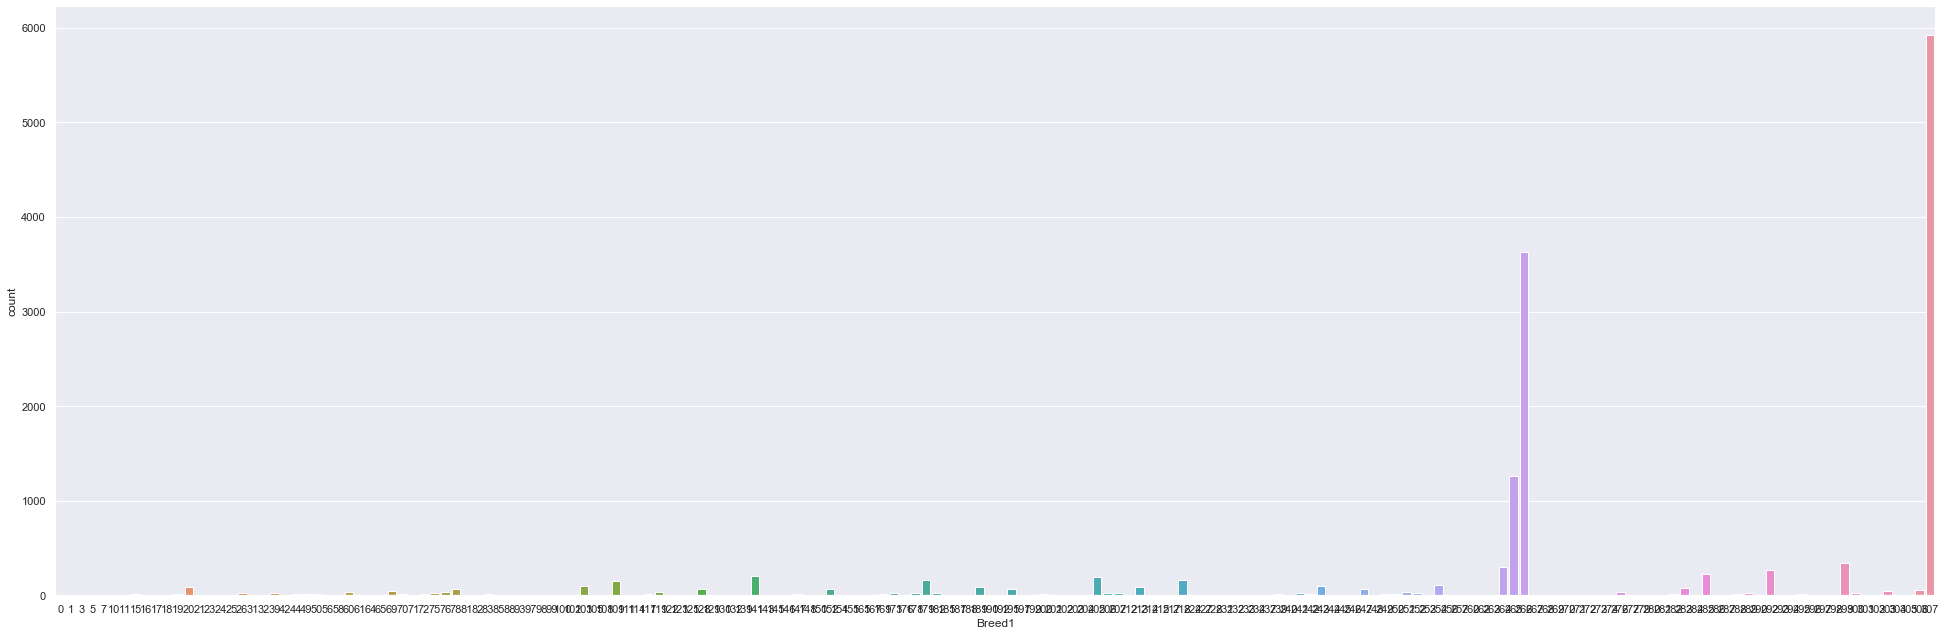

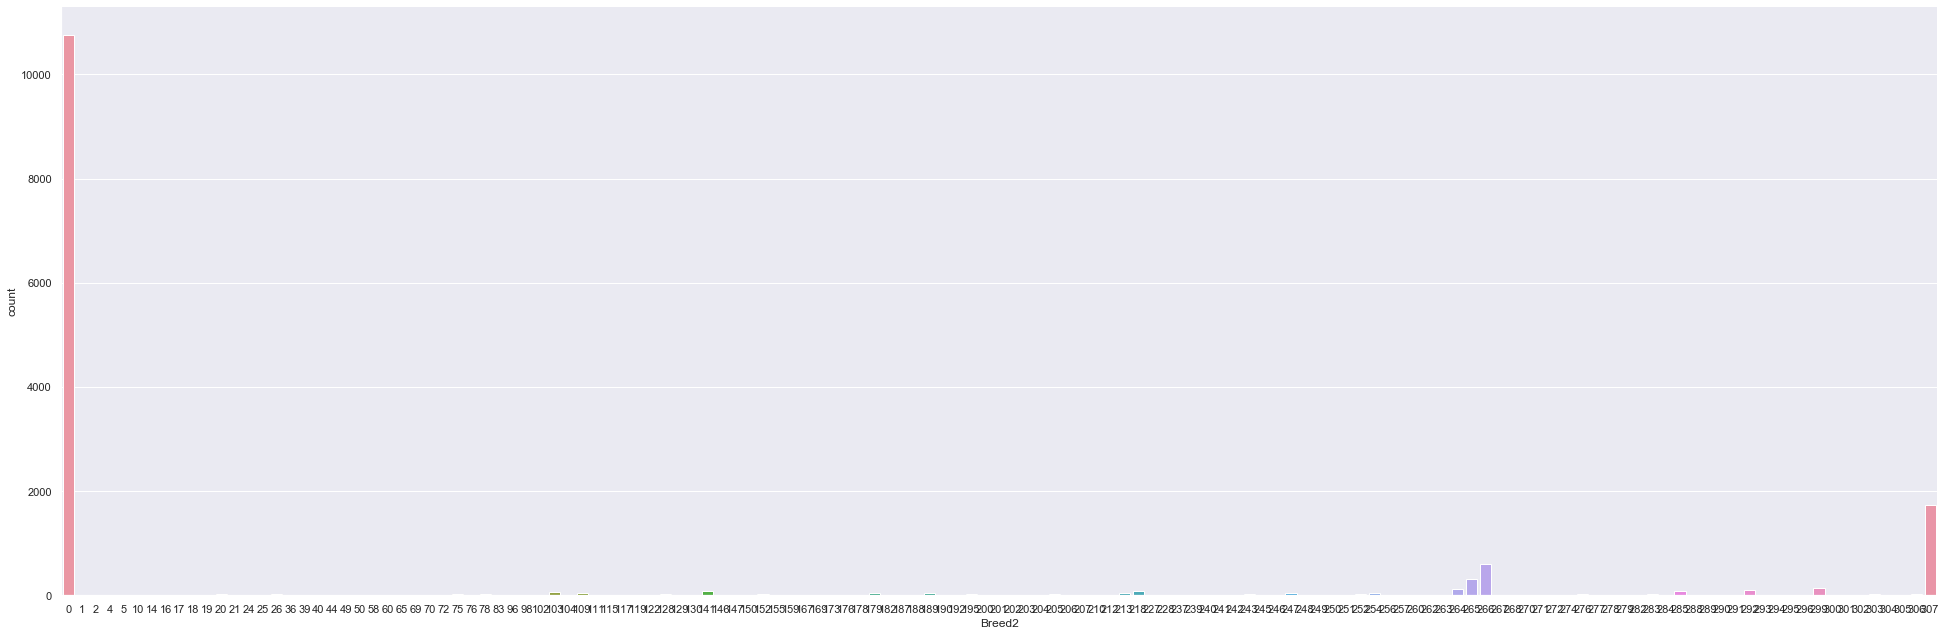

In [17]:
bx1 = sns.catplot(x="Breed1",data=df, kind='count',height=9, aspect=3)
bx2 = sns.catplot(x="Breed2",data=df, kind='count',height=9, aspect=3)

Looking at our data, and according to the breeds feature labels, we found some cats with dogs breeds assigned to them (15, 21, 25, 70, 114, 205, 218, 307).
Therefore, and given the distribution of pets by breeds in which some breeds are poorly representated perhaps a good idea should be grouping pets by pure-race/mixed-race.

In [18]:
#Creating new feature: Pure breed
l3 =[]
for i in range(len(df)):
    if df['Breed1'][i]==307 or df['Breed2'][i]==307:
        l3.append(0)
    elif df['Breed1'][i]!=307 and df['Breed2'][i]==0:
        l3.append(1)
    elif df['Breed1'][i]==0 and df['Breed2'][i]!=307:
        l3.append(1)
    elif df['Breed1'][i]==df['Breed2'][i]:
        l3.append(1)
    else:
        l3.append(0)
        
df_processed2.drop("Breed1",axis=1,inplace=True)
df_processed2.drop("Breed2",axis=1,inplace=True) 
df_processed2.insert(3,'PureBreed',l3) ##INSERT IN DATAFRAME

In [ ]:
cat_distr_pairwise('AdoptionSpeed','PureBreed', df_processed2, frel=True)

From the plot and relative gain table we conclude that pure breed animals (1) tend to be adopted earlier, whereas mixed breed animals (0) are adopted later.

### Quantity

Number of pets represented in profile

There are 11565 profiles with a single pet
There are 3428 profiles with multiple pets


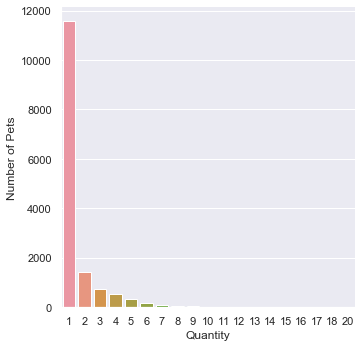

In [19]:
ax3 = sns.catplot(x='Quantity', data=df, kind='count')
(ax3.set_axis_labels("Quantity", "Number of Pets"))
print('There are {} profiles with a single pet'.format((list(df['Quantity'])).count(1)))
print('There are {} profiles with multiple pets'.format(len(df['Quantity'])-list(list(df['Quantity'])).count(1)))

In [ ]:
ste = cat_distr_pairwise('AdoptionSpeed','Quantity', df, frel=True)

The "inf" values on the table indicate that there are no examples of a pet with AdoptionSpeed=0 for that feature instance. Therefore, all positive relative gains are 'infinite'.

We can conclude that adds containing more than 5 pets could be more likely to be ignored, since those pets are adopted after a long time.

### Fee

After observing the fees distribution we considered 4 categories: 
* Free => 0
* Tens => 1
* Hundreds => 2
* Thousands => 3


In [20]:
f=[]
for i in df["Fee"]:
    if i==0:
        f.append(0)
    elif i<100:
        f.append(1)
    elif i<1000:
        f.append(2)
    else:
        f.append(3)

df_processed2.drop("Fee",axis=1,inplace=True) 
df_processed2.insert(4,'Free',f) ##INSERT IN DATAFRAME

In [ ]:
fee = cat_distr_pairwise('AdoptionSpeed','Free', df_processed2, frel=True)

It seems that pets with fees in the order of the thousands are less likely to be adopted fast.

### RescuerID

In order to extract some meaning from the 'RescuerID', we decided to create a new feature "FrequentRescuer" which indicates whether it is frequent for rescuers to save and advertise pets.

There are 5595 total rescuers in the dataset
There are 3783 rescuers with only 1 webpage entry in the dataset
There are 1812 rescuers with more than 1 webpage entry in the dataset


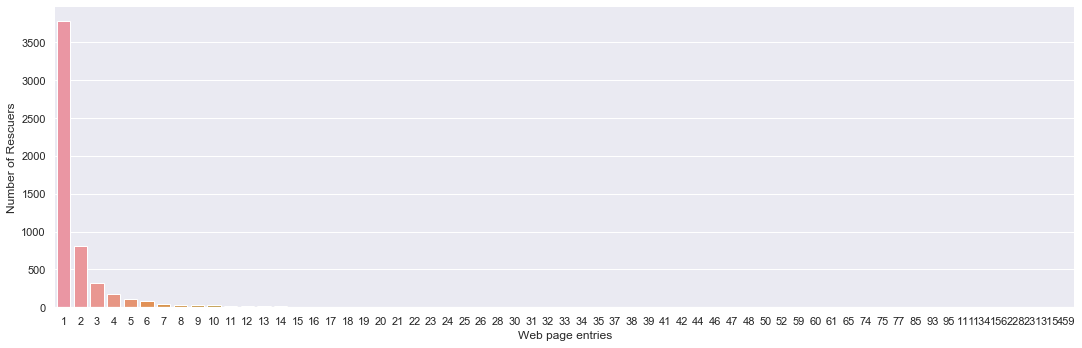

In [21]:
x = list(df['RescuerID'].unique())
y = list(df['RescuerID'])
z = []
t = {}
for i in x:
    z.append(y.count(i))

t['Rescuer'] = x
t['entries'] = z

e = pd.DataFrame(t)
print('There are {} total rescuers in the dataset'.format(len(x)))
print('There are {} rescuers with only 1 webpage entry in the dataset'.format(z.count(1)))
print('There are {} rescuers with more than 1 webpage entry in the dataset'.format(len(x)-(z.count(1))))
ax11 = sns.catplot(x='entries', data=e, kind='count', height=5, aspect=3)
(ax11.set_axis_labels("Web page entries", "Number of Rescuers")
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

According to the dataset, the number of rescuers with a single entry in the MyPet webpage is greater than the number of rescuers who save and advertise more than 1 pet. This information could be useful on later anaylsis to discover whether the number of webpage profile entries associated with a rescuer has any interference in pet's apoption or adoption speed.

In [22]:
#CREATE NEW FEATURE FREQUENTRESCUER

lista2 = []
y = list(df['RescuerID'])
for i in df['RescuerID']:
      if y.count(i)>1:
          lista2.append(float(1))
      else:
          lista2.append(float(0))
          
df_processed1.insert((df.columns.get_loc("RescuerID"))+1,'FrequentRescuer',lista2) ##INSERT IN DATAFRAME
df_processed1.drop("RescuerID", axis=1, inplace=True)

df_processed2.insert((df.columns.get_loc("RescuerID"))+1,'FrequentRescuer',lista2) ##INSERT IN DATAFRAME
df_processed2.drop("RescuerID", axis=1, inplace=True)

### VideoAmt

There are 14419 profiles with 0 videos
There are 574 profiles with more than 0 videos


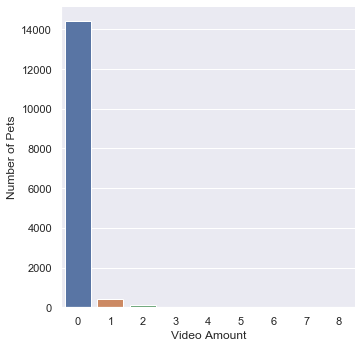

In [23]:
ax2 = sns.catplot(x='VideoAmt', data=df, kind='count')
(ax2.set_axis_labels("Video Amount", "Number of Pets"))
print('There are {} profiles with 0 videos'.format((list(df['VideoAmt'])).count(0)))
print('There are {} profiles with more than 0 videos'.format(len(df['VideoAmt'])-list(list(df['VideoAmt'])).count(0)))

Given the distribution of pets, we will consider this feature as binary: has Video (1) or does not have Video (0).

In [24]:
hasVideo=[]

for v in df['VideoAmt']:
    if v==0:
        hasVideo.append(0)
    else:
        hasVideo.append(1)
        
df_processed2.drop("VideoAmt", axis=1,inplace=True)
df_processed2.insert(5,"hasVideo",hasVideo) ##INSERT IN DATAFRAME

### Description

In order to extract some meaning from the 'Description', we decided, as a first approach, to partition this continuous feature into discrete values.

Since empty descriptions (size=0) probably have a direct influence in the adoption choice, it should be a category of its own. For that reason, we exclude empty descriptions from the discretization procces.

We consider that the discretization of the 'description sizes' based on the quantiles strategy is appropriate, since it is plausible to say that the ad writers define what a 'medium' size description is. In that sense, a 'medium' sized description would have the average word count. In analogy, the smallest and largest descriptions would correspond to the first and third quantiles.

The average descripton size: 62.953645034349364
According to this discretization, the bin edges should be:
[array([   0.,   28.,   65., 1257.])]


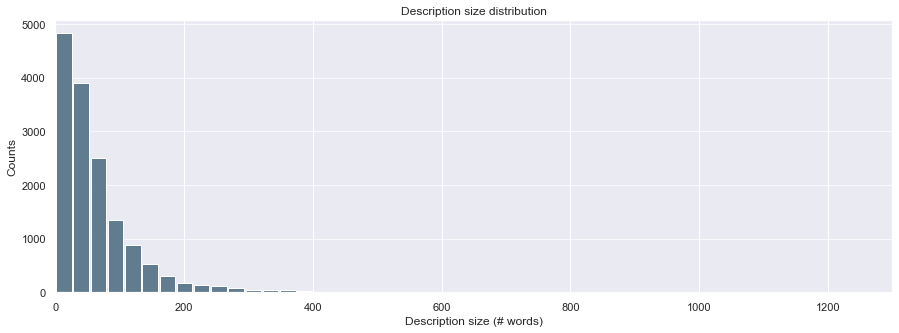

In [25]:
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
import statistics 

l=[]

# List descriptions' lengths (i.e. number of char)
for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        l.append(len(i.split()))

mean = statistics.mean(l)
print("The average descripton size:" , mean)

# Histogram
a1 = np.asarray(l)
nr_bins = 1 + 3.322*math.log(len(l),2) # Number of bins according to Sturges rule
a1 = pd.Series(a1)
a1.plot.hist(grid=True, bins = round(nr_bins), rwidth=0.9, color='#607c8e')
plt.title('Description size distribution')
plt.xlabel('Description size (# words)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.xlim([0.0,1300])

# Discretization by quantile strategy:
a2 = np.asarray(l).reshape(-1,1) # Reshape data since we are working with just one feature
est = preprocessing.KBinsDiscretizer(n_bins=[3],encode='ordinal', strategy='quantile').fit(a2)
decp = est.transform(a2)

print("According to this discretization, the bin edges should be:")
print(est.bin_edges_) # how the data is distributed in the four bins

Based on these results, we present a new feature 'DescriptionSize' whose possible values include:
* 'Empty' for descriptions containing 0 words => 0
* 'Small' for descriptions containing 1-28 words => 1
* 'Medium' for descriptions containing 29-65 words => 2
* 'Large' for descriptions containing 66-1257 words => 3

In [26]:
#Create new feature 'Description size'
d = []

for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        d.append(0)
    else:
        a= len(i.split())
        if a<29:
            d.append(1)
        elif a<66:
            d.append(2)
        else:
            d.append(3)    
            
df_processed1.drop("Description", axis=1, inplace=True)
df_processed1.insert(6,"DescriptionSize",l) ##INSERT IN DATAFRAME

df_processed2.drop("Description", axis=1, inplace=True)
df_processed2.insert(6,"DescriptionSize",d) ##INSERT IN DATAFRAME

### Other conclusions
* Pets with maturity size 'Small' (1) and 'Extra Large'(4) are less likely to be in the adoption centre for a very long time (-45.0552% and -97.3772 of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1, respectively). 
* Pets with long fur(3) very rarely stay at the adoption centre for a long time (-116.814% of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1).
* Sterilized pets tend to be adopted later (+82.13% of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1).
* Pets with serious injuries (Health=3) are very more likely to be adopted after a long time, or not adopted at all (+182.091% of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1). 
* No pets were adopted in the same day having the add not provide a description!
* There was no clear evidence that the distribution of the features values among AdoptionSpeed classes was biased for features Gender, Vaccinated, Dewormed, States, FrequentRescuer.

## Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed

## 1.1. Preprocessing Data for Classification

During our EDA we already preprocessed some of the features, for data visualization purposes. The result are two datasets:
* **df_processed1**: which we will use to benchmark the models' performance without the discretization of features discussed earlier, since they can remove the fine grain information that might be beneficial to the learning proccess. Some data cleaning was done, namely in features PetID, Name, RescuerID and DescriptionSize (in words, instead of text Description).

* **df_processed2**: which is the data set with the derived features and data cleaning. We will see if the dicretization will be helpful for the models or not.

### Features impact

Now that we have preprocessed our features, one way to determine the impact of each one on prediction models is to apply a random forest. Based on that information, we will  discard some features that have low impact and are probably causing noise.

Bellow we have a function that will apply a random forest model to any data set.
Code obtained from: <https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e>

Random forest algorithms seek to maximise impurity decreases from node to node in each tree. Features are considered more important the more they decrease impurity in datasets amongst the entire random tree population that was generated.

In [27]:
def random_forest(df_x, df_y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=test_size, random_state=12)
    rf = RandomForestClassifier() 
    rf.fit(X_train, y_train) 
    score = rf.score(X_test, y_test)
    feature_importance = pd.DataFrame(rf.feature_importances_, index = df_x.columns, columns=['importance']).sort_values('importance',ascending=False).reset_index().rename(columns = {'index':'column'})
    return score, feature_importance

#### Original features importance (df_processed1)

In [28]:
score1, feature_importances1 = random_forest(
    df_processed1[df_processed1.columns.difference(['AdoptionSpeed'])],
    df_processed1['AdoptionSpeed'],
    0.2)
print("Score: ",score1)
print(feature_importances1)

/Users/air/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: '1bb6183eb'

#### Extracted features importance (df_processed2)

In [ ]:
score2, feature_importances2 = random_forest(
    df_processed2[df_processed2.columns.difference(['AdoptionSpeed'])], 
    df_processed2['AdoptionSpeed'],
    0.2)

print("Score: ",score2) 
print(feature_importances2)

We conclude that, after our feature extractions, some features are actually contributing less to the model then they were before:
* DescriptionSize-in bins (DescriptionSize- nr. words)
* AgeGroup (Age)
* PureBreed (Breed1, Breed2)

We will go back to the original features in the classifiers analysis.
Some are doing slightly better/did not get worse so we will keep the changes:
* hasVideo (VideoAmt)
* Free (Fee)

In [29]:
#APPLY CHANGES TO DATASET - REVERT TO ORIGINAL FEATURES
#Description
df_processed2.drop("DescriptionSize", axis=1, inplace=True)
df_processed2.insert(6,"DescriptionSize",df_processed1['DescriptionSize'])

#AgeGroup
df_processed2.drop("AgeGroup", axis=1, inplace = True)
df_processed2.insert(2,"Age",df_processed1['Age'])

#PureBreed
df_processed2.drop("PureBreed", axis=1, inplace=True)
df_processed2.insert(6,"Breed1",df_processed1['Breed1'])
df_processed2.insert(6,"Breed2",df_processed1['Breed2'])

### Data imbalance

As we explained in the beggining there is a clear imbalance in the number of examples:
- Binary classification: the number of examples of AdoptionSpeed 0+1+2+3 (Adopted) is much greater than the number of examples for AdoptionSpeed 4 (Not Adopted).
- Multiclass classification: the number of examples of AdoptionSpeed 0 is much smaller than the rest of the Adoption Speeds.

Since we are working with such a small dataset, we cannot spare any examples, and we will resort to random oversampling to balance our data.

#### Binary Classification - Random Over-Sampling

In [30]:
#ADAPT TARGET COLUMN FOR BINARY CLASSIFICATION
df_processed2_b = df_processed2.copy()
df_processed2_b = df_processed2_b.rename(columns={'AdoptionSpeed': 'Adoption'})
df_processed2_b = df_processed2_b.replace({'Adoption':[0,2,3]},1)
df_processed2_b = df_processed2_b.replace({'Adoption':4},0)

In [31]:
#RANDOM OVERSAMPLING
ros_b = RandomOverSampler(sampling_strategy='minority',random_state=42) #create oversampling class
X_ros_b, y_ros_b = ros_b.fit_resample(df_processed2_b.iloc[:,:-1], df_processed2_b['Adoption']) #resample the oversampled dataset

# y_ros_b is a np array in some versions and a pd dataframe in others. 
# An object-type check must be applied in order to further proccess the data

if isinstance(y_ros_b, pd.DataFrame):
    df_processed2_b_balanced = X_ros_b.join(y_ros_b)
    
else:
    y_ros_b.shape = (21592,1) #reshape array for concatenation
    np_processed2_b_balanced = np.concatenate((X_ros_b, y_ros_b), axis=1) #save new data
    df_processed2_b_balanced = pd.DataFrame(data=np_processed2_b_balanced, columns=df_processed2_b.columns)

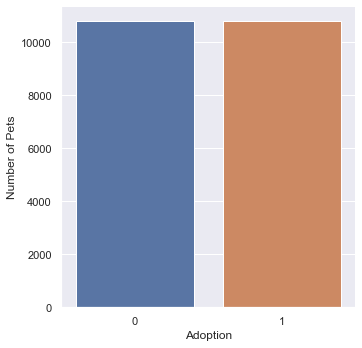

In [32]:
ax = sns.catplot(x="Adoption",data=df_processed2_b_balanced, kind='count')
(ax.set_axis_labels("Adoption", "Number of Pets"))

We can see that the oversampling was successful because we now have the same number of examples for adopted and not adopted pets, with a total of 21592 examples.

#### Multiclass classification - Random Over-Sampling

We can see that the oversampling was succesfull because we now have the same number of examples for all Adoption Speeds, with a total of 20985 examples.

In [33]:
#RANDOM OVERSAMPLING
df_processed2_m = df_processed2.copy()
ros_m = RandomOverSampler(random_state=42)
X_ros_m, y_ros_m = ros_m.fit_resample(df_processed2_m.iloc[:,:-1], df_processed2_m['AdoptionSpeed'])

# y_ros_b is a np array in some versions and a pd dataframe in others. 
# An object-type check must be applied in order to further proccess the data

if isinstance(y_ros_m, pd.DataFrame):
    df_processed2_m_balanced = X_ros_m.join(y_ros_m)
    
else:
    y_ros_m.shape = (20985,1) #reshape array for concatenation
    np_processed2_m_balanced = np.concatenate((X_ros_m, y_ros_m), axis=1) #save new data
    df_processed2_m_balanced = pd.DataFrame(data=np_processed2_m_balanced, columns=df_processed2_m.columns)

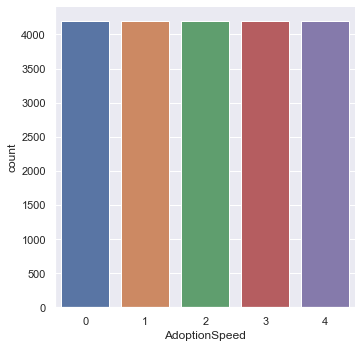

In [34]:
ax = sns.catplot(x="AdoptionSpeed",data=df_processed2_m_balanced, kind='count')

##### Dogs and Cats - preprocessing

In [35]:
# DOGS BINARY CLASSIFICATION
df_processed2_b_dogs = df_processed2_b_balanced.copy()
df_processed2_b_dogs = df_processed2_b_balanced[df_processed2_b_dogs['Type']==1]

# DOGS MULTICLASS CLASSIFICATION
df_processed2_m_dogs = df_processed2_m_balanced.copy()
df_processed2_m_dogs = df_processed2_m_dogs[df_processed2_m_dogs['Type']==1]

# CATS BINARY CLASSIFICATION
df_processed2_b_cats = df_processed2_b_balanced.copy()
df_processed2_b_cats = df_processed2_b_cats[df_processed2_b_cats['Type']==2]

# CATS MULTICLASS CLASSIFICATION
df_processed2_m_cats = df_processed2_m_balanced.copy()
df_processed2_m_cats = df_processed2_m_cats[df_processed2_m_cats['Type']==2]

### Feature encoding

Data encoding is a necessary step for categorical features. Our machine learning algorithms must receive numerical inputs, and as such, data organised in categories must be converted appropriately. We observe two distinct types of categorical features in our dataset:

1) ordinal categorical data, that is, data organised in classes which have a natural order to them;

2) nominal categorical data, that is, data organised in classes which are distinct and unordered.

Of the first kind, we observe features such as `MaturitySize`, `FurLength` and `Health`. These benefit from label encoding, also known as ordinal encoding, which converts each class to a numerical value that preserves the order in the category. However, the existence of a default value `0` for unspecified fields makes analysis of these features easier if considering standalone classes.

The remaining categorical features fit the second type. For these, one hot encoding is a good option. With this method, each class in the category becomes its own binary feature (it either exists or it doesn't in each data entry), therefore eliminating any underlying assumptions of order or distance between classes. This method tends to lose usefulness in cases of high cardinality features; tree-based models are more prone to overfit, as nodes will split in many possible values for each class in each category.

In [36]:
# This function allows the encoding of the features of a given dataset
# Inputs: 
# df- the dataframe we want to enconde
# enc_features- list of features we want to encode
# nonenc_features- list of features we don't want to encode
# Output: encoded dataset

def encode(df, enc_features, nonenc_features, binary):
    encoder = OneHotEncoder()
    df_encoded = encoder.fit_transform(df[enc_features]).toarray()
    column_name = encoder.get_feature_names(enc_features)
    df_result =  pd.DataFrame(df_encoded, columns= column_name)
    
    #INSERT THE PETID AS INDEX
    df_result.insert(0,'PetID',df.index.tolist())
    df_result.set_index("PetID", inplace=True) # change index to PetId
    
    # INSERT THE NON ENCODED FEATURES IN THE DATAFRAME AGAIN
    count=2
    for i in nonenc_features:
        df_result.insert(count,i,df[i]) 
        count+=1
        
    # INSERT THE TARGET CLASS
    if binary:
        df_result.insert((len(df_result.columns)),'Adoption',df['Adoption']) ## Adoption (binary)
    else:
        df_result.insert((len(df_result.columns)),'AdoptionSpeed',df['AdoptionSpeed']) ## AdoptionSpeed
    
    return df_result

In [37]:
### ENCODING FEATURES

#df_processed1
enc_features1 = ['Type','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']
nenc_features1 = ['hasName','Age','DescriptionSize','Quantity','Fee','FrequentRescuer','VideoAmt','PhotoAmt']
df_processed1_encoded = encode(df_processed1, enc_features1, nenc_features1, False)

#df_processed1_dogs
df_processed1_dogs = df_processed1.copy()
df_processed1_dogs = df_processed1_dogs[df_processed1_dogs['Type']==1] # Filter by Type=1
enc_features2 = ['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']
df_processed1_dogs_encoded = encode(df_processed1, enc_features2, nenc_features1, False)

#df_processed1_cats
df_processed1_cats = df_processed1.copy()
df_processed1_cats = df_processed1_dogs[df_processed1_cats['Type']==2] # Filter by Type=2
df_processed1_cats_encoded = encode(df_processed1, enc_features2, nenc_features1, False)

#df_processed2_b_balanced
nenc_features2 = ['hasName','Age','DescriptionSize','Quantity','Free','FrequentRescuer','hasVideo','PhotoAmt']
df_processed2_b_balanced_encoded = encode(df_processed2_b_balanced, enc_features1, nenc_features2, True)

#df_processed2_m_balanced
df_processed2_m_balanced_encoded = encode(df_processed2_m_balanced, enc_features1, nenc_features2, False)

/Users/air/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/air/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='au

### Pre-processing: final dataset
We have the following dataframes to feed the classifiers in the following phase:
* Binary task: df_processed2_b_balanced_encoded
* Multiclass task: df_processed2_m_balanced_encoded
* Dogs binary task: df_processed2_b_dogs_encoded
* Dogs multiclass task: df_processed2_m_dogs_encoded
* Cats binary task: df_processed2_b_cats_encoded
* Cats multiclass task: df_processed2_m_cats_encoded

Remember the (non encoded) features chosen for these datasets:

In [39]:
print(list(df_processed2_b_balanced.columns))

['Type', 'hasName', 'Age', 'Free', 'hasVideo', 'DescriptionSize', 'Breed2', 'Breed1', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'State', 'FrequentRescuer', 'PetID', 'PhotoAmt', 'Adoption']


________________

## 1.2. Learning Classifiers

In [40]:
# creates a framework for printing confusion matrices side by side
# X for some informative string
# y_train for the training set targets
# y_train_predict for the target predictions by the model
# y_test for the test set targets 
# y_test_predict for the test predictions by the model

def confusion (X,y_train,y_train_predict,y_test,y_test_predict):
    print('{}'.format(X))
    
    cm_train = confusion_matrix(y_train, y_train_predict)
    cm_test = confusion_matrix(y_test, y_test_predict)
    
    y = np.unique(y_train)
    z = np.unique(y_test)
    
    f, ax = plt.subplots(1,2) # defines two matrix plots, one for the training set and the other for the test set
    sns.heatmap(cm_train.T, square=True, annot = True, fmt='d', cbar=False,
                xticklabels=(y),
                yticklabels=(y),
                ax=ax[0]) # first plot
    ax[0].set_xlabel('true label')
    ax[0].set_ylabel('predicted label')
    ax[0].set_title('Confusion Matrix - Training Set')

    sns.heatmap(cm_test.T, square=True, annot = True, fmt='d', cbar=False,
                xticklabels=(z),
                yticklabels=(z),
                ax=ax[1]) # second plot
    ax[1].set_xlabel('true label')
    ax[1].set_ylabel('predicted label')
    ax[1].set_title('Confusion Matrix - Test Set')

In [41]:
# creates a framework for model fitting, scoring and target predictions
# takes xtrain, ytrain, xtest and ytest as arguments
# the arguments xtrain, ytrain, xtest and ytest come from splitting the dataset into training and test sets
# takes the classifier (model) as argument 
# prints classification reports for both training and test sets
# returns predicted targets for both training and test sets
# returns fitting scores (accuracy) for both training and test sets

def model (intro,xtrain,ytrain,xtest,ytest,model):
    print ("{}\n".format(intro))
    md = model.fit(xtrain,ytrain)
    print("Accuracy on training set:\n")
    trainscore = md.score(xtrain, ytrain)
    print("{}\n".format(trainscore))
    ytrainp = md.predict(xtrain)
    print('Classification report (training):')
    print(classification_report(ytrain,ytrainp))
    print("Accuracy on test set:\n") 
    testscore = md.score(xtest, ytest)
    print("{}\n".format(testscore))
    ytestp = md.predict(xtest)
    print('Classification report (test):')
    print(classification_report(ytest,ytestp))
    return ytrainp, ytestp, trainscore, testscore

## 1.2.1 Benchmark
Before going into training the classifiers with our altered datasets, we want to perform a benchmark of the original dataset's performance in the models (df_processed1).

In [42]:
# this function separates examples from targets
def separate(df):
    nc = df.shape[1]
    matrix = df.values # Convert dataframe to darray
    examples = matrix [:, 0:nc-1] # get features 
    target = matrix [:, nc-1] # get class (last columns)           
    fnames = df.columns.values[0:nc-1] #get features names
    tname = df.columns.values[nc-1] #get target name
    examples = examples.astype(float)
    target = target.astype(float)
    return examples, target, fnames, tname 

In [43]:
examples, target, fnames, tname = separate(df_processed1_encoded)

# SPLIT DATAFRAME INTO TEST AND TRAINING SETS
X_train, X_test, y_train, y_test = train_test_split(examples, target, random_state=0)

print("Number of examples and features for the training dataset: ", X_train.shape)
print("Number of examples and features for the test dataset: ", X_test.shape)

Number of examples and features for the training dataset:  (11244, 377)
Number of examples and features for the test dataset:  (3749, 377)


### 1.2.1.1 Predicting Adoption (binary classification task)

Since this is a binary task, `AdoptionSpeed` has to be converted into a binary target class (`0` for profiles with `AdoptionSpeed = 4` and `1` for profiles with `AdoptionSpeed < 4`)

In [44]:
# This function converts an array of multiclass AdoptionSpeed targets into binary classes
def binarize(table_y):
    for i in range(len(table_y)):
        if table_y[i]<4:
            table_y[i]=1
        else:
            table_y[i]=0
    return table_y

In [45]:
y_train_binary = binarize(y_train)
y_test_binary = binarize(y_test)

In [46]:
print("Number of positives cases in the training set is: {}".format(np.count_nonzero(y_train_binary == 1)))
print("Number of negative cases in the training set is: {}".format(np.count_nonzero(y_train_binary == 0)))
print("Ratio of positive to negative cases in the training set: {}".format((np.count_nonzero(y_train_binary == 1))/(np.count_nonzero(y_train_binary == 0))))

Number of positives cases in the training set is: 8078
Number of negative cases in the training set is: 3166
Ratio of positive to negative cases in the training set: 2.5514845230574856


Different types of machine learning algorithms will be used to solve the task, as a way to see which will be the most appropriate. Model hyperparameters' choice can be determined manually or via automatic methods, such as grid search.

In order to optimise the model, the grid search method does an exhaustive assessment of best hyperparameters for the estimator. The grid search will go through all possible hyperparameter combinations and evaluate each model using a few metrics for scoring.

5-fold cross-validation is the default model evaluation in this case. The training data is split in 5 equally-sized subsets (hence, the "5-fold"), and the model will be trained 5 times, each time leaving a different subset out, to be a test set. The performance of the model is the average of the performance over all (5) different test sets. Below, there is an image explaining the process.

<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png width="500">

#### K-Nearest Neighbours

In [47]:
knn_b = neighbors.KNeighborsClassifier(n_neighbors=3) ## 3 neighbors for starters
knn_b

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [48]:
# Defining and applying a grid search cross validation to find the best hyperparameters for the knn estimator 
# adequate metric, adequate p for the minkowski metric, adequate number of neighbours and weights

knn_b_p = {'metric': ['minkowski','chebyshev'],
           'p': [1,2,3,4,5],
           'n_neighbors': [2,4,6,8,10,20], # odd numbers were also tested, ommitted for running time sake
           # 'n_neighbors': [2,3,4,5,6,7], # alternative with even and odd numbers
           'weights': ['uniform','distance']}

There are 2 * 5 * 6 * 2 = 120 different combinations of hyperparameters, meaning that the grid search will create all these different versions of the model, which are then fit to the training data. Since each model goes through 5-fold cross-validation, there are 120 * 5 = 600 fits in total.

In [49]:
# The scoring metric for the grid searh in the benchmark task will be the score of the estimator (runs slow)
knn_b_grid = GridSearchCV(knn_b, knn_b_p, scoring='f1_macro',verbose=10) # creates all 120 versions of the KNN model
knn_b_grid.fit(X_train,y_train_binary) # 

/Users/air/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] metric=minkowski, n_neighbors=2, p=1, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=2, p=1, weights=uniform, score=0.577, total=   3.6s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=uniform ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=uniform, score=0.583, total=   3.6s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=uniform ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=uniform, score=0.580, total=   3.6s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=distance ..........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=distance, score=0.582, total=   3.6s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=distance ..........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.4s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=distance, score=0.592, total=   4.0s
[CV] metric=minkowski, n_neighbors=2, p=1, weights=distance ..........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.4s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=1, weights=distance, score=0.592, total=   4.1s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=uniform ...........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   22.5s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=2, weights=uniform, score=0.567, total=   2.5s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=uniform ...........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.0s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=2, weights=uniform, score=0.572, total=   2.3s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=uniform ...........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.3s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=2, weights=uniform, score=0.561, total=   2.8s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=distance ..........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.1s remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, p=2, weights=distance, score=0.574, total=   1.9s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=distance ..........
[CV]  metric=minkowski, n_neighbors=2, p=2, weights=distance, score=0.582, total=   2.0s
[CV] metric=minkowski, n_neighbors=2, p=2, weights=distance ..........
[CV]  metric=minkowski, n_neighbors=2, p=2, weights=distance, score=0.579, total=   2.2s
[CV] metric=minkowski, n_neighbors=2, p=3, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=2, p=3, weights=uniform, score=0.557, total=   6.2s
[CV] metric=minkowski, n_neighbors=2, p=3, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=2, p=3, weights=uniform, score=0.562, total=   6.7s
[CV] metric=minkowski, n_neighbors=2, p=3, weights=uniform ...........
[CV]  metric=minkowski, n_neighbors=2, p=3, weights=uniform, score=0.565, total=   8.5s
[CV] metric=minkowski, n_neighbors=2, p=3, weights=distance ..........
[CV]  metric=minkowski, n_neighbors=2, p=3,

KeyboardInterrupt: 

In [ ]:
knn_b_grid.best_estimator_ # finding the best hyperparameters from the grid search
knn_b = knn_b_grid.best_estimator_ # assigning the parameters to the KNN estimator
knn_b

In [ ]:
y_train_pred_b_knn, y_test_pred_b_knn, trainscore_b_knn, testscore_b_knn = model('KNN',X_train,y_train_binary,X_test,y_test_binary,knn_b)

In [ ]:
confusion ('KNN',y_train_binary,y_train_pred_b_knn,y_test_binary,y_test_pred_b_knn)

#### NAIVE BAYES

In [ ]:
gnb_b = GaussianNB()
gnb_b

In [ ]:
y_train_pred_b_GNB, y_test_pred_b_GNB, trainscore_b_GNB, testscore_b_GNB = model('GNB',X_train,y_train_binary,X_test,y_test_binary,gnb_b)

In [ ]:
confusion ('Naive',y_train_binary,y_train_pred_b_GNB,y_test_binary,y_test_pred_b_GNB)

#### DECISION TREES

In [ ]:
dec_trees_b = tree.DecisionTreeClassifier() # criterion = "Gini"

dec_trees_b

In [ ]:
y_train_pred_b_trees, y_test_pred_b_trees, trainscore_b_trees, testscore_b_trees = model('DECISION TREES',X_train,y_train_binary,X_test,y_test_binary,dec_trees_b)

In [ ]:
confusion ('Dec Trees',y_train_binary,y_train_pred_b_trees,y_test_binary,y_test_pred_b_trees)

#### Support Vector Machines

In [ ]:
lsvm_b = LinearSVC(max_iter=15000) # max_iter=1000 (default) ## Didnt converge
lsvm_b

In [ ]:
y_train_pred_b_svm, y_test_pred_b_svm, trainscore_b_svm, testscore_b_svm = model('Support Vector Machine',X_train,y_train_binary,X_test,y_test_binary,lsvm_b)

In [ ]:
confusion ('SVC',y_train_binary,y_train_pred_b_svm,y_test_binary,y_test_pred_b_svm)

#### Logistic Regression

In [ ]:
logreg_b = LogisticRegression(solver='lbfgs', max_iter=4000)
logreg_b

In [ ]:
y_train_pred_b_logr, y_test_pred_b_logr, trainscore_b_logr, testscore_b_logr = model('Logistic Regression',X_train,y_train_binary,X_test,y_test_binary,logreg_b)

In [ ]:
confusion ('LogR',y_train_binary,y_train_pred_b_logr,y_test_binary,y_test_pred_b_logr)

Given these results we conclude that:
* 

### 1.2.1.2 Predicting AdoptionSpeed (Multiclass classification task)

#### KNN

In [ ]:
knn_m = neighbors.KNeighborsClassifier()
knn_m

In [ ]:
# Defining and applying a grid search cross validation to find the best hyperparameters for the knn estimator 
# adequate metric, adequate p for the minkowski metric, adequate number of neighbours and weights
knn_m_p ={'metric':['minkowski','chebyshev'],
          'p':[1,2,3,4,5],
          'n_neighbors':[2,4,6,8,10,20],
          'weights':['uniform','distance']}

In [ ]:
# The scoring metric for the grid searh in the benchmark task will be the score of the estimator (runs slow)
knn_m_grid = GridSearchCV(knn_m, knn_m_p, scoring='f1_macro',verbose=10) #used f1 score as a scoring metric for grid searc cv
knn_m_grid.fit(X_train,y_train)

In [ ]:
knn_m_grid.best_estimator_ #finding the best hyperparameters from the grid seach
knn_m = knn_m_grid.best_estimator_ #assigning the parameters to the knn estimator
knn_m

In [ ]:
y_train_pred_m_KNN, y_test_pred_m_KNN, trainscore_m_knn, testscore_m_knn = model('KNN',X_train,y_train,X_test,y_test,knn_m)

In [ ]:
confusion ('KNN',y_train,y_train_pred_m_KNN,y_test,y_test_pred_m_KNN)

* From the test set confusion matrix we understand the model clearly overfitted on the training data with perfect accuracy.
* The model didn't perform that well on the test set mainly due to the precision and recall performance of the adoption speed=0 class which lowers the overall performance of this metric.

This results are based on the unbalanced dataset. Perhaps with the random oversampling the overall performance of this model will increase.

#### PROBABILISTIC MODELS

For the task of prediting adoption speed using probabilistic models we considered 4 distinct Naive Bayes approaches:
* Gaussian Naive Bayes
* Multinomial Naive Bayes
* Bernoulli Naive Bayes
* Complement Naive Bayes

In [ ]:
gnb_m = GaussianNB() # gaussian naive bayes
mnb_m = MultinomialNB() # multinomial naive bayes
bnb_m = BernoulliNB() # bernoulli naive bayes
knb_m = ComplementNB() # Complement naive bayes

##### Gaussian Naive Bayes

In [ ]:
y_train_pred_m_GBN, y_test_pred_m_GBB, trainscore_m_gnb, testscore_m_gnb = model('Gaussian Naive Bayes',X_train,y_train,X_test,y_test,gnb_m)

In [ ]:
confusion ('GaussianNaiveBayes',y_train,y_train_pred_m_GBN,y_test,y_test_pred_m_GBB)

* The gaussian bayes classifier performed decently both on training and test sets on identifying the elements of the minority class with a almost perfect recall. However, the model seems to have failed in identifying the characteristics that separate the minority class from the other classes as expressed in a low precision value.

* For the remaining classes the precision is better but the model fails to identify all the relevant samples from each category (low recall).

##### Multinomial Naive Bayes

In [ ]:
y_train_pred_m_MNB, y_test_pred_m_MNB, trainscore_m_MNB, testscore_m_MNB = model('Multinomial Naive Bayes',X_train,y_train,X_test,y_test,mnb_m)

In [ ]:
confusion ('MultinomialNaiveBayes',y_train,y_train_pred_m_MNB,y_test,y_test_pred_m_MNB)

##### Bernoulli Naive Bayes

In [ ]:
y_train_pred_m_BNB, y_test_pred_m_BNB, trainscore_m_BNB, testscore_m_BNB = model('Bernoulli Naive Bayes',X_train,y_train,X_test,y_test,bnb_m)

In [ ]:
confusion ('BernoulliNaiveBayes',y_train,y_train_pred_m_BNB,y_test,y_test_pred_m_BNB)

##### Complement Naive Bayes

In [ ]:
y_train_pred_m_KNB, y_test_pred_m_KNB, trainscore_m_KNB, testscore_m_KNB = model('Complement Naive Bayes',X_train,y_train,X_test,y_test,knb_m)

In [ ]:
confusion ('ComplementNaiveBayes',y_train,y_train_pred_m_KNB,y_test,y_test_pred_m_KNB)

* All models besides the Gaussian Naive Bayes present similar results in regards to the overall performance of the model.
* All models have a farly similiar performance on both training and test sets which might hint underfitting.
* Amongst the three remaining models, Bernoulli Naive Bayes shows a better overall compromise between precision and recall, although it fails to "understand" the minority class.
* Oversampling and perhaps feature normalization would help improving the models values.

#### DECISION TREES

In [ ]:
dec_trees_m = tree.DecisionTreeClassifier()
dec_trees_m

In [ ]:
# Defining and applying a grid search cross validation to find the best hyperparameters for the Decision tree estimator
dec_trees_p ={'class_weight':[None,'balanced'],
          'criterion':['gini','entropy'],
          'max_features':[None,'auto','log2'],
          'min_samples_leaf':[1,2,3,4,5,6],
          'min_samples_split':[2,3,4,5]}

dec_trees_m_grid = GridSearchCV(dec_trees_m, dec_trees_p, scoring='f1_macro',verbose=10)
dec_trees_m_grid.fit(X_train,y_train)

In [ ]:
dec_trees_m_grid.best_estimator_
dec_trees_m = dec_trees_m_grid.best_estimator_
dec_trees_m

In [ ]:
y_train_pred_m_trees, y_test_pred_m_trees, trainscore_m_trees, testscore_m_trees = model('DECISION TREES',X_train,y_train,X_test,y_test,dec_trees_m)

In [ ]:
confusion ('Decision Trees',y_train,y_train_pred_m_trees,y_test,y_test_pred_m_trees)

* The performance on the training set is good which doesn't happen on the test set. This might indicate overfitting.
* The performance on the test set is decent being clearly spoiled by the minority class.

#### LINEAR MODELS

For the linear model task of predicting pet's adoptions speeds we will test four different approaches:
* Linear Support Vector Machines
* Logistic Regression
* Perceptron
* Ridge Classifier

For each of this approaches we will use grid search to find the best possible hyperparameters for each model using each estimators score as the performance metric for grid search.

In [ ]:
# Defining and applying a grid search cross validation to find the best hyperparameters for each linear estimator
lsvm_m_p = {'C':[0.001,0.01,0.1,1,10],
            'class_weight':[None,'balanced'],
            'loss':['hinge','squared_hinge'],
            'max_iter':[10000],
            'penalty':['l2']}

lreg_m_p = {'C':[0.001, 0.01,0.1,1,10],
            'class_weight':[None,'balanced'],
            'max_iter':[7000],
            'multi_class':['auto'],
            'penalty':['l2'],
            'solver':['lbfgs','newton-cg']}

per_m_p = {'alpha':[0.0001,0.001,0.01,0.1,1,10],
          'class_weight':[None,'balanced'],
          'early_stopping':[True],
          'max_iter': [5000],
          'n_iter_no_change':[10],
          'penalty':[None,'l1','l2']}

rdcl_m_p = {'alpha':[0.0001,0.001,0.01,0.1,1,10],
          'class_weight':[None,'balanced'],
          'max_iter': [5000],
          'normalize':[True,False],
          'solver':['auto','svd', 'cholesky', 'lsqr', 'sparse_cg']}

* Linear support vector machine

In [ ]:
lsvm_m = LinearSVC(max_iter=40000) # linear support vector machine
lsvm_m

In [ ]:
y_train_pred_m_lsvm, y_test_pred_m_lsvm, trainscore_m_lsvm, testscore_m_lsvm = model('Linear Support Vector Machine',X_train,y_train,X_test,y_test,lsvm_m)

In [ ]:
confusion ('Linear Support Vector Machines',y_train,y_train_pred_m_lsvm,y_test,y_test_pred_m_lsvm)

Linear support vector machine failed do converge with as much as 40000 iterations. This might indicate this is not a good model for this task. We won't therefore be using this model for feature optimization.

* Logistic regression model

In [ ]:
lreg_m = LogisticRegression() # logistic regression
lreg_m

In [ ]:
lreg_m_grid = GridSearchCV(lreg_m, lreg_m_p, scoring='f1_macro',verbose=10)
lreg_m_grid.fit(X_train,y_train)

In [ ]:
lreg_m = lreg_m_grid.best_estimator_
lreg_m

In [ ]:
y_train_pred_m_lregm, y_test_pred_m_lregm, trainscore_m_lregm, testscore_m_lregm = model('Logistic Regression',X_train,y_train,X_test,y_test,lreg_m)

In [ ]:
confusion ('Logistic Regression',y_train,y_train_pred_m_lregm,y_test,y_test_pred_m_lregm)

During the iterative process of finding the best hyperparameters some converge warnings were presented hinting the need for dataset scaling. Perhaps this should be a good approach.

* The perceptron

In [ ]:
per_m = Perceptron() # Perceptron
per_m

In [ ]:
per_m_grid = GridSearchCV(per_m, per_m_p, scoring='f1_macro', verbose=10)
per_m_grid.fit(X_train,y_train)

In [ ]:
per_m = per_m_grid.best_estimator_
per_m

In [ ]:
y_train_pred_m_perm, y_test_pred_m_perm, trainscore_m_perm, testscore_m_perm = model('Perceptron',X_train,y_train,X_test,y_test,per_m)

In [ ]:
confusion ('Perceptron',y_train,y_train_pred_m_perm,y_test,y_test_pred_m_perm)

* Ridge Classifier

In [ ]:
rdcl_m =  RidgeClassifier() #Ridge Classifier
rdcl_m

In [ ]:
rdcl_m_grid = GridSearchCV(rdcl_m, rdcl_m_p, scoring='f1_macro',verbose=10)
rdcl_m_grid.fit(X_train,y_train)

In [ ]:
rdcl_m = rdcl_m_grid.best_estimator_
rdcl_m

In [ ]:
y_train_pred_m_rdclm, y_test_pred_m_rdclm, trainscore_m_rdclm, testscore_m_rdclm = model('Ridge Classifier',X_train,y_train,X_test,y_test,rdcl_m)

In [ ]:
confusion ('Ridge Classifier',y_train,y_train_pred_m_rdclm,y_test,y_test_pred_m_rdclm)

* Conclusions

### 1.2.3. Predicting pet-specific models

For this part we will only test the models that had the best performance on the previous tasks, namely XXXXX

#### 1.2.3.1 DOGS (Type 1)

##### Binary Classification

In [ ]:
examples, target, fnames, tname = separate(df_processed1_dogs_encoded)
target_b = binarize(target)

##### Multiclass Classification

In [ ]:
examples, target, fnames, tname = separate(df_processed1_dogs_encoded)

#### 1.2.3.2 CATS (Type 2)

##### Binary Classification

In [ ]:
examples, target, fnames, tname = separate(df_processed1_cats_encoded)
target_b = binarize(target)

##### Multiclass Classification

In [ ]:
examples, target, fnames, tname = separate(df_processed1_cats_encoded)

## 1.2.2 Predicting Adoption (binary classification task)

## 1.2.3 Predicting Adoption Speed (Multiclass classification task)

## 1.2.4 Predicting Adoption/Adoption Speed for dogs

## 1.2.5 Predicting Adoption/Adoption Speed for cats

## 1.3. Classification - Results and Discussion 

## Task 2 (Unsupervised Learning) - Charactering Adopted Pets and Adoption Speed

In this task you should **use unsupervised learning algorithms and try to characterize pets that were actually adopted and their adoption speed**. You can use:
* **Association rule mining** to find **associations between the features and the target Adoption/AdoptionSpeed**.
* **Clustering algorithms to find similar groups of pets**. Is it possible to find groups of pets with the same/similar adoption speed.
* **Be creative and define your own unsupervised analysis!** What would it be interesting to find out ?

## 2.1. Preprocessing Data for Association Rule Mining

...

## 2.2. Finding Associations

...

## 2.3 Association Rules - Results and Discussion 

...

## 2.4. Preprocessing Data for Clustering

For this task we will use the same processed dataset as we used for the Binary and Multiclass Classification tasks, df_processed2_b_balanced_encoded and df_processed2_m_balanced_encoded. k-Means uses distance computation as a metric in its algorithm, and hence cannot handle categorical variable directly. That is the reason why we use the encoded datasets.

In [51]:
## SPLIT THE DATASET
nc_b = df_processed2_b_balanced_encoded.shape[1] # number of columns
table_X_b = df_processed2_b_balanced_encoded.iloc[:, 0:nc_b-1] # get features ignoring AdoptionSpeed
table_y_b = df_processed2_b_balanced_encoded.iloc[:, nc_b-1] # get class (last columns) 

nc_m = df_processed2_m_balanced_encoded.shape[1] # number of columns
table_X_m = df_processed2_m_balanced_encoded.iloc[:, 0:nc_m-1] # get features ignoring AdoptionSpeed
table_y_m = df_processed2_m_balanced_encoded.iloc[:, nc_m-1] # get class (last columns) 

Each dimension has the same weight in the k-means algorithm, but since our data has dimensions in different scales (some are binary, ranging from 1 to 0 while others are continuous, ranging from 0 to 250 - `Age`) we will proceed to standardizing the data, in order to avoid distortion on the relative near-ness of observations.

In [52]:
## STANDARDIZING THE DATA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled_b = scaler.fit_transform(table_X_b)
data_scaled_m = scaler.fit_transform(table_X_m)

## 2.5. Finding Groups

In order to find out if it's possible to find groups of pets with the same/similar adoption speed, we will look at the k=2 and k=5 clusters obtained from k-Means and determine whether they coincide with the AdoptionSpeed groups.

In [53]:
from sklearn.cluster import KMeans
kmeans_b = KMeans(n_clusters=2, random_state=0)
kmeans_m = KMeans(n_clusters=5, random_state=0)

In [54]:
# Train K-means
kmeans_b = kmeans_b.fit(data_scaled_b)
kmeans_m = kmeans_m.fit(data_scaled_m)

In [55]:
# This function produces a confusion matrix with the percentual membership
# (of the points in each cluster) to a given feature

def df_confusion(cluster, table_a):
    df = pd.DataFrame(set(table_a))
    df = df.set_index(0)

    for i in set(cluster): df[i] = 0 
    i=0
    while i < len(cluster):
        df.loc[table_a[i], cluster[i]]+=1
        i += 1
    for i in set(df.columns): 
        Total = df[i].sum()
        for j in set(df.index):
            df.loc[j, i] = (df.loc[j, i] / Total)
    return df

### 2.5.1 Binary analysis

Text(111.5, 0.5, 'true label')

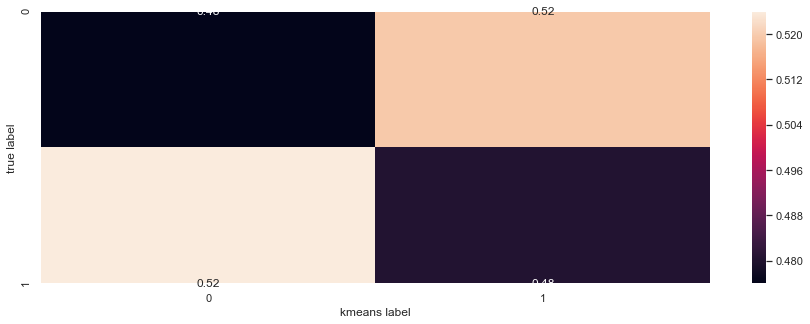

In [56]:
# Compare membership for binary dataset
df1 = df_confusion(kmeans_b.labels_, table_y_b)
ax = sns.heatmap(df1, annot=True)
ax.set_xlabel('kmeans label')
ax.set_ylabel('true label')

### 2.5.1 Multiclass analysis

Text(111.5, 0.5, 'true label')

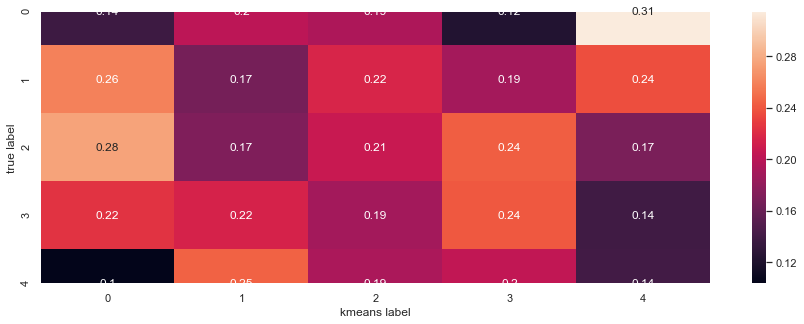

In [57]:
# Compare membership for multiclass dataset
df2 = df_confusion(kmeans_m.labels_, table_y_m)
ax = sns.heatmap(df2, annot=True)
ax.set_xlabel('kmeans label')
ax.set_ylabel('true label')

## 2.6. Clustering - Results and Discussion 

In respect to the Binary analysis, we can see in the confusion matrix that the negative examples are evenly distributed through both clusters obtained from k-means, and the same happens for the positive examples. Thus, we conclude that the groups obtained from k-means do not coincide with the groups from the target class. 

In the Multiclass analysis, the confusion matrix indicates that none of the clusters hold more than 30% of examples from any AdoptionSpeed class, thus we conclude that there is no evident agreement between the predicted clusters and the real target groups.

These poor results can be explained due to the complexity and high dimensionality of the dataset, because when we have so many features (378) distance interpretation isn’t so obvious. An additional step employing Principal Component Analysis to reduce dimensionality might've helped get more productive results. 

## 3. Final Comments and Conclusions

...